# Neoclassical transport for an axisymmetric plasma

Currently a work in progress.

# Houlberg_1997

Equation 6:

$$F_\alpha^{ai} = \int m_a v L_{\alpha-1}^{3/2}(x_a^2)C_{ai} dv$$


$$<F_\alpha^{ai} \cdot B> = \sum_{b,j,\beta} l_{\alpha \beta}^{ai, bj} \hat{u}_\beta^{bj}$$


$$l_{\alpha \beta} ^{ai, bj} = \xi_{ai}(\delta_{ai,bj} M_{\alpha\beta}^a + \xi_{bj} N_{\alpha \beta}^{ab})$$

$$\xi_{ai} = n_{ai} Z_i^2 / \sum_i n_{ai} Z_i^2$$

$$\mu_{\alpha \beta}^{ai} = \frac{8}{3 \sqrt\pi} n_{ai} m_a (-1)^{\alpha + \beta} \times \int_0^\infty dx x^4 e^{-x^2} L_{\alpha-1}^{3/2} L_{\beta-1}^{3/2} \bar{K}^{ai}$$

$$\bar{K}^{ai} = K_B K_{PS} / (K_B + K_{PS})$$
(upuściłem superskrypt ai wszędzie);
$K_B, K_{PS}$ zdefiniowane w appendix B

Equation 23:

$$\sum_\beta (\xi_{ai} M^a_{\alpha \beta} - \hat{\mu}^{ai}_{\alpha\beta}) \hat{\mu}_\beta^{ai} - (\beta_{cx,a} + \beta_{an,\alpha}) \hat{u}_\alpha^{ai} 
= 
- \xi_{ai} =\sum_\beta \sum_b N^{ab}_{\alpha \beta} \bar{\mu}_\beta^b + \sum_\beta \hat{\mu}_{\alpha\beta}^{ai}S_{\theta,\beta}^{ai} - S_{E_\parallel,\alpha}^{ai} - S_{NBI\parallel, \alpha}^{ai}$$

$$\bar{\mu}_\beta^b = \sum_j \xi_{bj} \hat{\mu}_\beta^{bj}$$

Eventually we can go back to $$D^{C,\alpha} = \frac{- \Gamma^{C,\alpha}}{n_c \nabla(\ln \alpha)}$$

for $\alpha \in \{ T_e, T_i, n_e, n_D, n_C \}$

Eq. 41a:

$$\Gamma_{BP}^{ai} = -\hat{F} e_{ai}^{-1} \sum_\beta \hat{\mu}_{1\beta}^{ai} \hat{u}_{\theta,\beta}^{ai}$$

And the other gammas... around eq. 43

TODO assume we can skip heat flows for now. That's 41b

In [1]:
from plasmapy.particles import IonizationStateCollection

all_species = IonizationStateCollection(
    {
        "H": [0, 1],
        #      "D": [0, 1],   raises ParticleError, why?
        "C": [0, 0, 0, 0, 0, 0, 1],
    },
    n0=1e20 * u.m ** -3,
    abundances={"H": 1, "C": 0.08},
    T_e=10 * u.eV,
)
a = all_species["H"]
i = 1
ai = a[i]
all_species["H"].n_e

<Quantity 1.e+20 1 / m3>

In [2]:
h1 = all_species["H"][1]
h1.number_density, h1.T_i

(<Quantity 1.e+20 1 / m3>, <Quantity 116045.1812155 K>)

# Flux surface

TODO: przesłać do p. Moniki, p. Sławka, informacje, co potrzebowalibyśmy jako input do symulacji dla WESTa czy czegokolwiek

TODO: podpytać p. Iwonkę i p. Marynę o schemat danych z WESTa

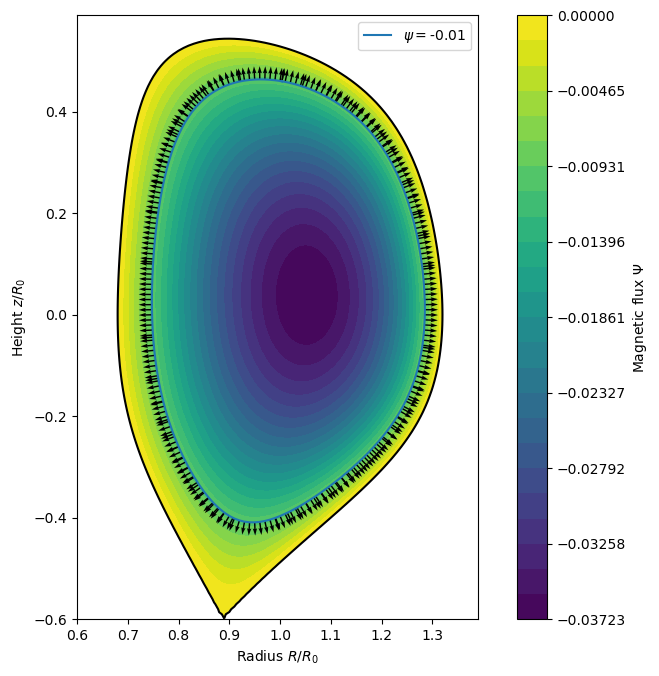

In [4]:
import plasmaboundaries

from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = plasmaboundaries.ITER.copy()
assert params["triangularity"] <= 0.841  # for convex plasma surfaces
eq = SymbolicEquilibrium(**params, B0=5.2, config="single-null")
ax = eq.plot()
fs = flux_surface = eq.get_flux_surface(-0.01)
fs.plot(ax, n=True);

# Convergence tests for the integrand

In [5]:
import itertools

from scipy import integrate
from tqdm.auto import tqdm

from plasmapy.formulary.neoclassical import _integrand

  0%|          | 0/36 [00:00<?, ?it/s]

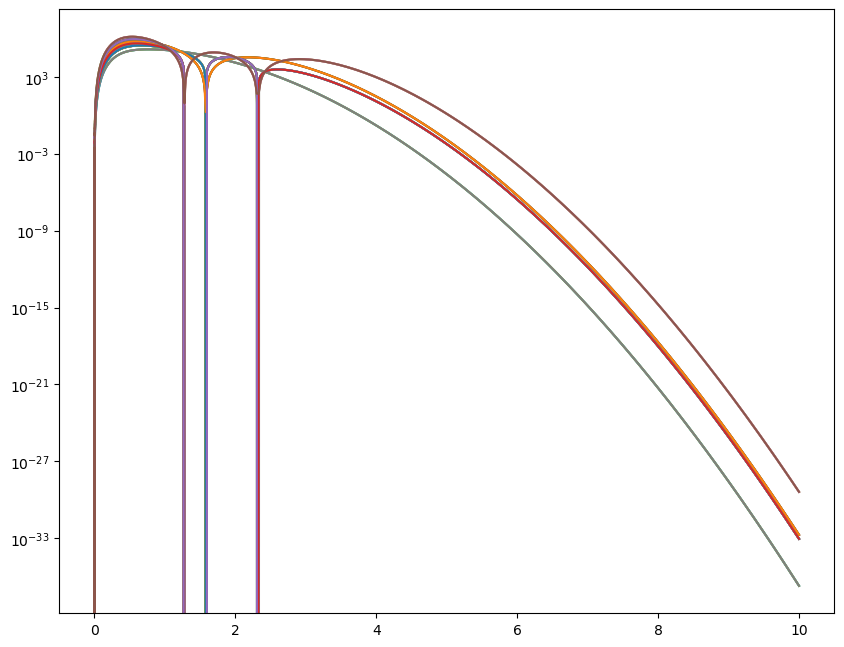

In [9]:
data = []
for (xmin, xmax, N, α, β) in tqdm(
    list(
        itertools.product(
            [0.0015, 0.015, 0.15, 0.00015],
            #     [0.015],
            #     [5],
            [10],
            [1000],
            #     [1000, 10000, 100],
            [1, 2, 3],
            [1, 2, 3],
        )
    )
):

    x = np.logspace(np.log10(xmin), np.log10(xmax), N)
    # x = np.logspace(-2.8, 1, 1000)
    y = _integrand(x, α, β, i, a, all_species, fs)
    integral = integrate.trapezoid(y, x)
    #         quad_integral = integrate.quad(_integrand, xmin, xmax, args=
    #                                       (α, β, i, a, all_species, fs))
    #         quad_integral, quad_unc = quad_integral
    quad_integral = integral
    diff = integral - quad_integral
    plt.plot(
        x, y, label=f"{(α,β)=}, {integral=:.3e}, {quad_integral=:.3e}, {diff=:.3e}"
    )
    data.append(dict(xmin=xmin, xmax=xmax, integral=integral.si.value, α=α, β=β, N=N))
plt.yscale("log")
# plt.legend()

In [10]:
import pandas as pd

df = pd.DataFrame(data)
df.head()

,xmin,xmax,integral,α,β,N
0,0.0015,10,153804.053068,1,1,1000
1,0.0015,10,207399.115946,1,2,1000
2,0.0015,10,234493.959365,1,3,1000
3,0.0015,10,207399.115946,2,1,1000
4,0.0015,10,438699.819509,2,2,1000


/usr/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='α', ylabel='integral'>

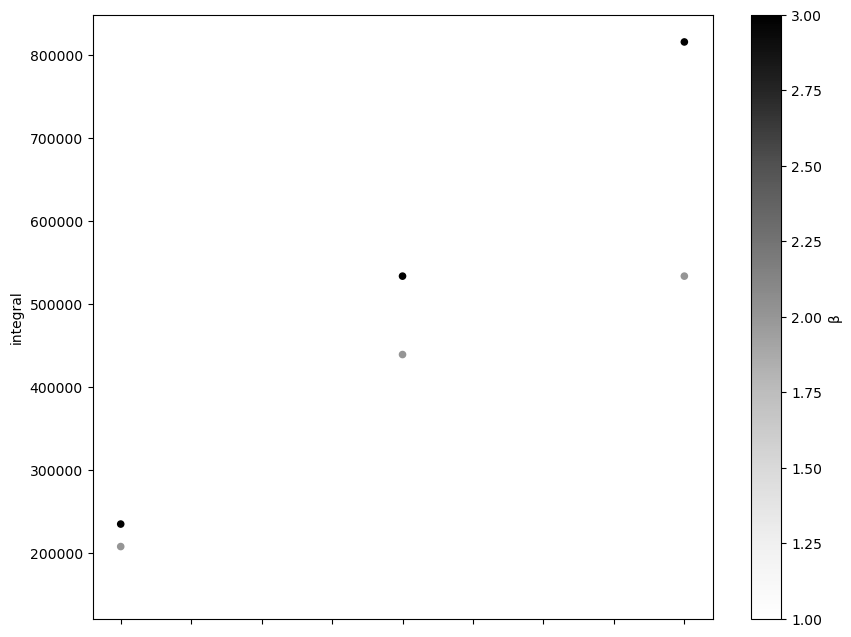

In [11]:
df.query("xmin== 0.00150 and xmax==10 and N==1000").plot.scatter(
    x="α", y="integral", c="β"
)

# n

In [12]:
n = fs.Bvectors / np.linalg.norm(fs.Bvectors, axis=0)

array([[-0.98521589, -0.98754886, -0.99292411, -0.99690886, -0.99933367,
        -0.99997023, -0.99852257, -0.99461898, -0.98780621, -0.9803798 ,
        -0.97753789, -0.96314592, -0.94397373, -0.91933435, -0.91903923,
        -0.88833103, -0.85288766, -0.85061845, -0.80555078, -0.78664763,
        -0.75327231, -0.72275842, -0.69418454, -0.662898  , -0.62920897,
        -0.60773976, -0.55983797, -0.55738366, -0.51201947, -0.4876193 ,
        -0.4709447 , -0.43396757, -0.4147462 , -0.40062043, -0.37058828,
        -0.34334662, -0.34308594, -0.31881977, -0.29648763, -0.27611071,
        -0.27396481, -0.25757712, -0.24057413, -0.22491594, -0.21044854,
        -0.20812382, -0.19708077, -0.18463807, -0.17300005, -0.16206756,
        -0.15175078, -0.14363902, -0.14197198, -0.13266729, -0.12374861,
        -0.11515396, -0.10682602, -0.09871153, -0.09076079, -0.08292723,
        -0.07516702, -0.06743875, -0.06280167, -0.05970379, -0.0519243 ,
        -0.04406377, -0.03608858, -0.02796661, -0.0

## Curved plots

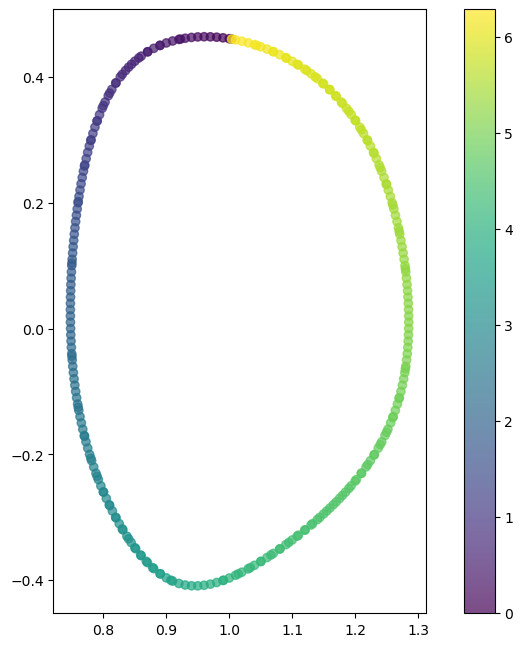

In [14]:
def plot_on_curve(y):
    plt.scatter(fs.R, fs.Z, c=y, alpha=0.7)
    plt.gca().set_aspect("equal")
    plt.colorbar()


plot_on_curve(fs.Theta)

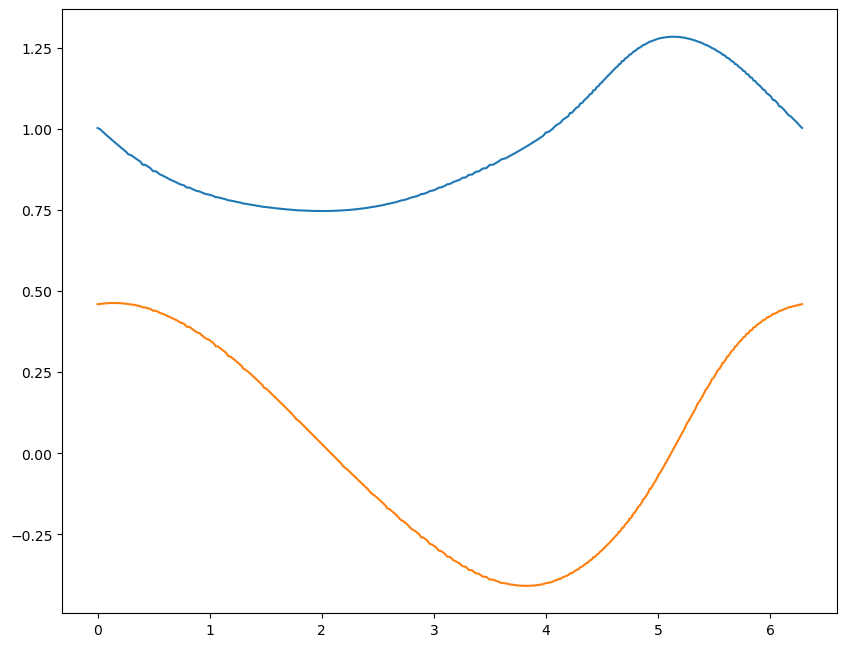

In [17]:
plt.plot(fs.Theta, fs.R)
plt.plot(fs.Theta, fs.Z)

In [18]:
np.gradient(fs.theta, fs.lp) * n

array([[-1.23595307e+00, -1.07967002e+00, -4.20591615e-01,
         8.73256936e-03,  4.18100171e-03, -1.15147016e-03,
        -7.37559295e-03,  1.89404512e-01,  1.43298188e+00,
         8.83745011e-01, -7.42216856e-01, -5.44038995e-01,
         1.64183222e+00,  1.20650176e+00, -4.59901063e-01,
         1.03080007e+00,  1.00684525e+00, -3.79853937e-01,
         1.60014642e-01,  2.10644771e-01, -4.32524509e-02,
         1.00870382e-01, -8.00363170e-02,  9.51770679e-02,
        -1.02254231e-02,  1.90061527e-01,  2.76796251e-01,
        -2.12355999e-01,  3.58650755e-01,  3.23328283e-01,
        -2.43932017e-01,  3.92595267e-01,  2.53905925e-01,
        -3.19074173e-01,  5.83866601e-01,  4.77792791e-01,
        -1.44184440e-01, -2.18365703e-01,  4.27673526e-01,
         3.39692876e-01, -6.48900071e-02, -1.90297761e-01,
        -1.60904194e-02,  2.82762966e-01,  2.46650774e-01,
        -2.81145358e-02, -1.50871062e-01, -2.05729020e-02,
         9.26807489e-04,  2.31968162e-02,  2.39881781e-0

In [19]:
fs.theta

array([0.01058178, 0.01930281, 0.02796037, 0.02785126, 0.02778475,
       0.02776753, 0.02780788, 0.02791603, 0.02464866, 0.01411895,
       0.01776574, 0.02884757, 0.02941154, 0.01503371, 0.01537102,
       0.03022592, 0.0159317 , 0.01767184, 0.02335152, 0.01780471,
       0.02118272, 0.01917108, 0.01926086, 0.02097362, 0.01798637,
       0.02332257, 0.01710984, 0.01725798, 0.02571466, 0.01594577,
       0.02219176, 0.02420127, 0.01527926, 0.02167887, 0.02991413,
       0.01502672, 0.0146993 , 0.02913862, 0.02908737, 0.01610465,
       0.01439892, 0.0271239 , 0.02860844, 0.02850537, 0.01662398,
       0.01417774, 0.02592321, 0.02825074, 0.02819308, 0.02814204,
       0.02565624, 0.01403693, 0.01645386, 0.02801189, 0.02798056,
       0.02795229, 0.02792672, 0.02790356, 0.02788256, 0.02786353,
       0.02784632, 0.02226781, 0.01391155, 0.01946741, 0.02780374,
       0.02779338, 0.02778458, 0.02777742, 0.02777197, 0.02776835,
       0.02776672, 0.02776724, 0.02777013, 0.02777561, 0.02778

In [20]:
fs.flux_surface_average(fs.Bp * np.gradient(fs.theta, fs.lp),)

-0.02555000918169212

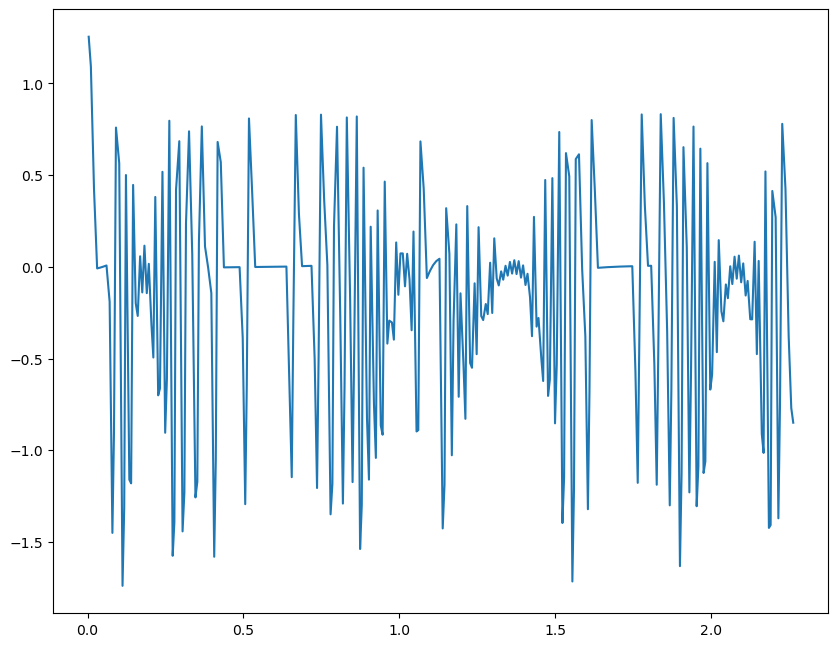

In [21]:
plt.plot(fs.lp, np.gradient(fs.theta, fs.lp))

# Toroidal flux

In [24]:
R, Z = eq.symbols

Okay. I think I'm starting to get it.

I need to calculate the toroidal and poloidal flux from this.

The toroidal flux...

also,

> $\sqrt{g}$ is the Jacobian of the transformation from cylindrical coordinates to flux coordinates,

So this would be... $(R, Z, \phi) \to (\psi, \theta, \phi)$...

In [25]:
fs.theta

array([0.01058178, 0.01930281, 0.02796037, 0.02785126, 0.02778475,
       0.02776753, 0.02780788, 0.02791603, 0.02464866, 0.01411895,
       0.01776574, 0.02884757, 0.02941154, 0.01503371, 0.01537102,
       0.03022592, 0.0159317 , 0.01767184, 0.02335152, 0.01780471,
       0.02118272, 0.01917108, 0.01926086, 0.02097362, 0.01798637,
       0.02332257, 0.01710984, 0.01725798, 0.02571466, 0.01594577,
       0.02219176, 0.02420127, 0.01527926, 0.02167887, 0.02991413,
       0.01502672, 0.0146993 , 0.02913862, 0.02908737, 0.01610465,
       0.01439892, 0.0271239 , 0.02860844, 0.02850537, 0.01662398,
       0.01417774, 0.02592321, 0.02825074, 0.02819308, 0.02814204,
       0.02565624, 0.01403693, 0.01645386, 0.02801189, 0.02798056,
       0.02795229, 0.02792672, 0.02790356, 0.02788256, 0.02786353,
       0.02784632, 0.02226781, 0.01391155, 0.01946741, 0.02780374,
       0.02779338, 0.02778458, 0.02777742, 0.02777197, 0.02776835,
       0.02776672, 0.02776724, 0.02777013, 0.02777561, 0.02778

In [26]:
eq.Bphifunc(fs.R, fs.Z)

array([5.46453496, 5.4850357 , 5.5404401 , 5.59697521, 5.65467598,
       5.71357886, 5.77372179, 5.83514437, 5.89788785, 5.94617612,
       5.96199533, 6.02751176, 6.09448412, 6.16296146, 6.1636916 ,
       6.23299512, 6.30061458, 6.30463874, 6.37794849, 6.40599293,
       6.45298318, 6.49338492, 6.52980441, 6.5681566 , 6.60847675,
       6.63358426, 6.68906793, 6.69187823, 6.74362244, 6.77164902,
       6.79079101, 6.83366613, 6.85629463, 6.87301882, 6.90908011,
       6.94275968, 6.94308317, 6.97346386, 7.00223832, 7.02924302,
       7.03209706, 7.05410809, 7.07744247, 7.09941243, 7.12010803,
       7.12342299, 7.13929482, 7.15732409, 7.17432087, 7.19033764,
       7.20542015, 7.21715224, 7.21956715, 7.23267596, 7.24497154,
       7.25647645, 7.26720872, 7.27718213, 7.28640649, 7.29488779,
       7.30262846, 7.3096275 , 7.31338094, 7.31584763, 7.32127636,
       7.32595336, 7.3298653 , 7.33299622, 7.33532771, 7.33683905,
       7.33750737, 7.33730782, 7.33621376, 7.33419696, 7.33122

In [27]:
eq.psisym

0.158880549818861*R**6*log(R) - 0.242130465792633*R**6 - 1.90656659782633*R**4*Z**2*log(R) + 2.11116284041729*R**4*Z**2 + 1.03225576390713*R**4*Z*log(R) - 1.21928447789883*R**4*Z + 0.685680913491688*R**4*log(R) + 0.0605795696983575*R**4 + 1.27104439855089*R**2*Z**4*log(R) - 0.45415859469836*R**2*Z**4 - 1.37634101854284*R**2*Z**3*log(R) + 0.593456873291304*R**2*Z**3 - 2.74272365396675*R**2*Z**2*log(R) - 1.72186101926849*R**2*Z**2 + 1.82053363212871*R**2*Z*log(R) + 1.00037447444355*R**2*Z + 0.170105095815133*R**2*log(R) + 0.077677567602565*R**2 - 0.0847362932367259*Z**6 + 0.137634101854284*Z**5 + 0.457120608994459*Z**4 - 0.606844544042904*Z**3 - 0.247605095815133*Z**2 + 0.207902760827392*Z + 0.0680021178661666

In [28]:
fs.Bphivals

array([5.46453496, 5.4850357 , 5.5404401 , 5.59697521, 5.65467598,
       5.71357886, 5.77372179, 5.83514437, 5.89788785, 5.94617612,
       5.96199533, 6.02751176, 6.09448412, 6.16296146, 6.1636916 ,
       6.23299512, 6.30061458, 6.30463874, 6.37794849, 6.40599293,
       6.45298318, 6.49338492, 6.52980441, 6.5681566 , 6.60847675,
       6.63358426, 6.68906793, 6.69187823, 6.74362244, 6.77164902,
       6.79079101, 6.83366613, 6.85629463, 6.87301882, 6.90908011,
       6.94275968, 6.94308317, 6.97346386, 7.00223832, 7.02924302,
       7.03209706, 7.05410809, 7.07744247, 7.09941243, 7.12010803,
       7.12342299, 7.13929482, 7.15732409, 7.17432087, 7.19033764,
       7.20542015, 7.21715224, 7.21956715, 7.23267596, 7.24497154,
       7.25647645, 7.26720872, 7.27718213, 7.28640649, 7.29488779,
       7.30262846, 7.3096275 , 7.31338094, 7.31584763, 7.32127636,
       7.32595336, 7.3298653 , 7.33299622, 7.33532771, 7.33683905,
       7.33750737, 7.33730782, 7.33621376, 7.33419696, 7.33122

# Appendix B

### F_m and its unknown values

0.011100302951168404

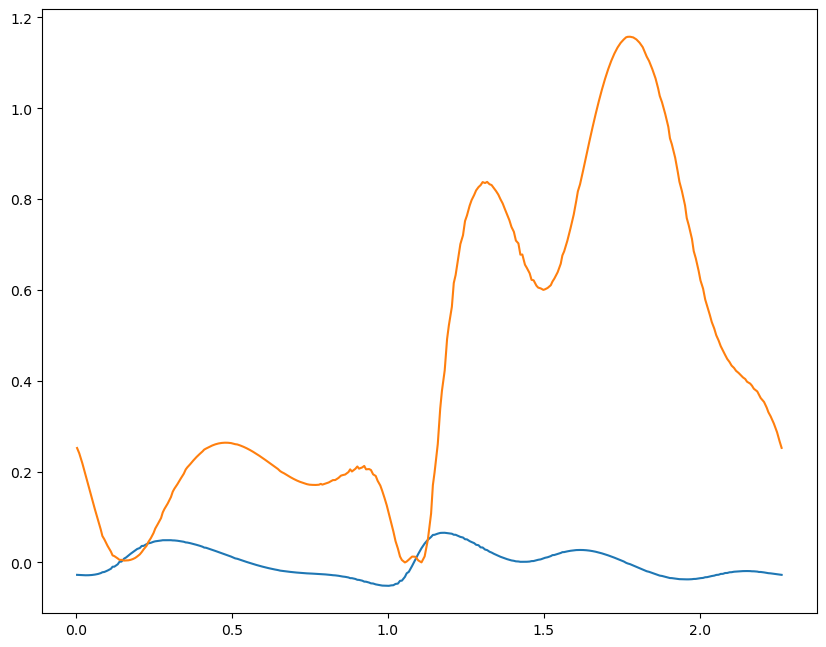

In [29]:
Theta = fs.Theta
B20 = fs.Brvals * fs.Bprimervals + fs.Bzvals * fs.Bprimezvals
plt.plot(fs.lp, B20)

# B17
Bprimevectors = np.stack((fs.Bprimervals, fs.Bprimezvals))

under_average_B17 = np.array(
    [np.dot(ni, Bpi) ** 2 for (ni, Bpi) in zip(fs.n.T, Bprimevectors.T)]
)
plt.plot(fs.lp, under_average_B17)
B2mean = fs.flux_surface_average(fs.B2)
B17 = fs.flux_surface_average(under_average_B17) / B2mean

In [30]:
num_m = 10000


from plasmapy.formulary.neoclassical import F_m

# optimization = optimize.minimize_scalar(optimizer)
mrange = range(1, 2 * num_m)
F_ms = np.array([F_m(m, fs, 1) for m in mrange])

array([2.05133175e-07, 7.03688248e-05, 2.79454073e-06, ...,
       9.48091170e-07, 2.87558715e-07, 3.72433825e-06])

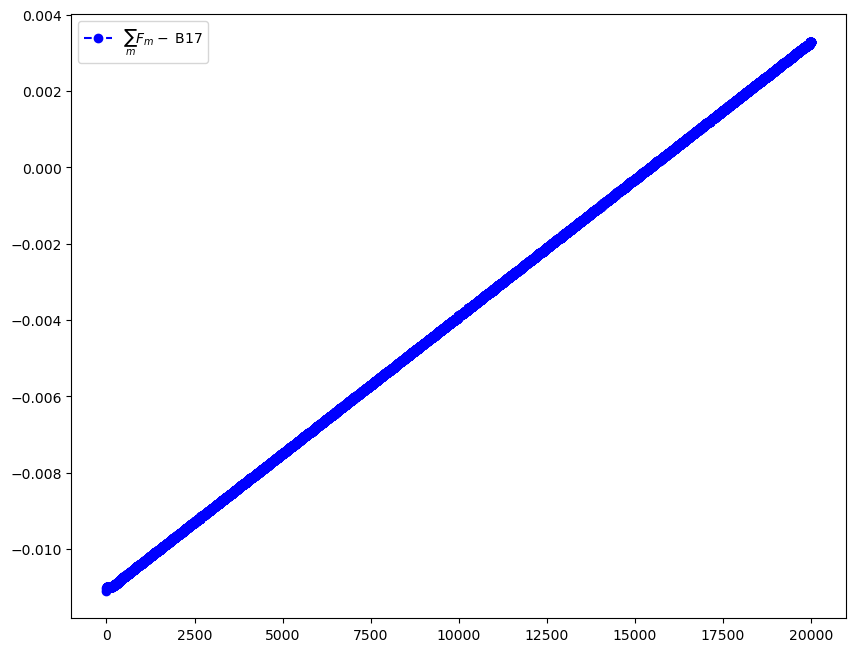

In [31]:
cumsum = np.cumsum(F_ms)

plt.plot(cumsum - B17, "bo--", label=r"$\sum_m F_m -$ B17")
# plt.axhline(0, color="black"
#            )
# plt.yscale("log")
# plt.xticks(mrange)
plt.legend()

So this probably sucks as a solution, a little.

In [32]:
from plasmapy.formulary.neoclassical import K_ps_ai

K_ps_ai(1, 1, a, all_species, fs, g=optimization.x, m_max=100)

NameError: name 'optimization' is not defined

In [ ]:
from plasmapy.formulary.neoclassical import K_B_ai

In [ ]:
K_B_ai(1, 1, a, all_species, fs)

$$[K_B^{ai}] = \frac{1}{1} \frac{[\nu_{D,ai}]}{1}$$

$$[\nu_{D,ai}] = s^{-1}$$

In [33]:
from plasmapy.formulary.neoclassical import ν_T_ai

ν_T_ai(1, 1, a, all_species)

<Quantity 24638301.15254432 1 / s>

In [34]:
from plasmapy.formulary.neoclassical import mu_hat, ωm

In [35]:
from plasmapy.formulary import thermal_speed

## \nu_T_ai

In [36]:
from scipy.special import erf

from plasmapy.formulary import thermal_speed
from plasmapy.formulary.mathematics import Chandrasekhar_G
from plasmapy.formulary.neoclassical import (
    effective_momentum_relaxation_rate,
    xab_ratio,
    ξ,
)

x = np.logspace(-3, 6, 5000)

ai = a[i]
prefactor = 3 * np.pi ** 0.5 / 4 * ξ(a)[i] / ai.number_density / ai.ion.mass


def gen():
    for b in all_species:
        if b.base_particle != a.base_particle:  # TODO is not should work
            x_over_xab = x / xab_ratio(a, b).si.value
            part1 = erf(x_over_xab) - 3 * Chandrasekhar_G(x_over_xab) / x ** 3
            part2 = 4 * (a.T_e / b.T_e + xab_ratio(a, b) ** -2)  # TODO adjust ratios
            part2full = part2 * Chandrasekhar_G(x_over_xab) / x
            yield (part1 + part2full) * effective_momentum_relaxation_rate(a, b)


result = prefactor * sum(gen())

<Quantity [-3.15477856e+13, -3.12872990e+13, -3.10289631e+13, ...,
            8.09962829e+06,  8.09962829e+06,  8.09962829e+06] 1 / s>

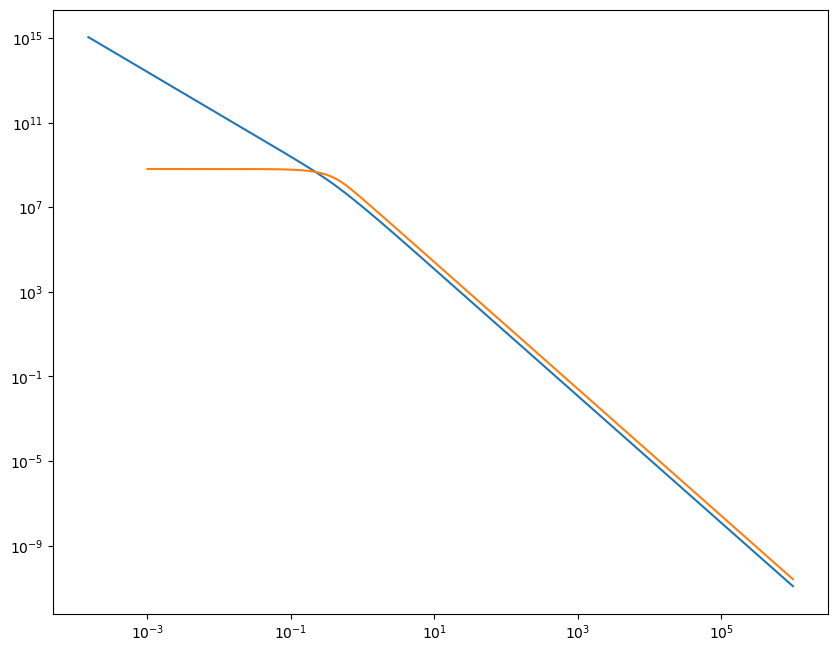

In [37]:
from plasmapy.formulary.mathematics import Chandrasekhar_G
from plasmapy.formulary.neoclassical import K_B_ai, pitch_angle_diffusion_rate

x = np.logspace(np.log10(xmin), 6, 5000)
ν_D_ai = pitch_angle_diffusion_rate(x, 1, a, all_species)
k = K_B_ai(x, 1, a, all_species, flux_surface)
g = Chandrasekhar_G(x)
plt.loglog(x, k)
x = np.logspace(-3, 6, 5000)
plt.loglog(x, ν_T_ai(x, i, a, all_species))

## K_ps_ai

(100,) (100, 5000)
full_sum=<Quantity [ 2.08065240e+02,  8.51525668e+03, -7.99912001e+03, ...,
            9.66237005e-15,  9.62239777e-15,  9.58259086e-15] s>


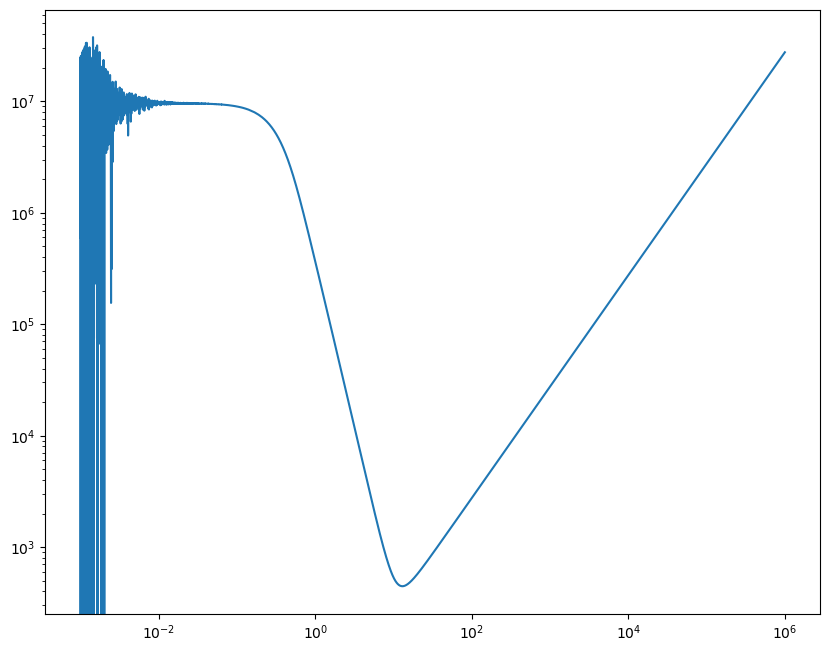

In [38]:
ai = a[i]
ν = ν_T_ai(x, i, a, all_species)

flux_surface = fs
# g = optimization.x
g = 1
m_max = 100
m = np.arange(1, m_max + 1)
F = F_m(m[:, np.newaxis], flux_surface, g=g)  # TODO replace
ω = ωm(x, m[:, np.newaxis], a, flux_surface)
B10 = (
    1.5 * (ν / ω) ** 2
    - 9 / 2 * (ν / ω) ** 4
    + (1 / 4 + (3 / 2 + 9 / 4 * (ν / ω) ** 2) * (ν / ω) ** 2)
    * (2 * ν / ω)
    * np.arctan(ω / ν).si.value
)
print(F.shape, B10.shape)
onepart = F[:, np.newaxis] * B10
full_sum = np.sum(onepart / ν, axis=0)
print(f"{full_sum=}")

out = 3 / 2 * thermal_speed(a.T_e, a.base_particle) ** 2 * x ** 2 * full_sum / u.m ** 2

plt.loglog(x, out)

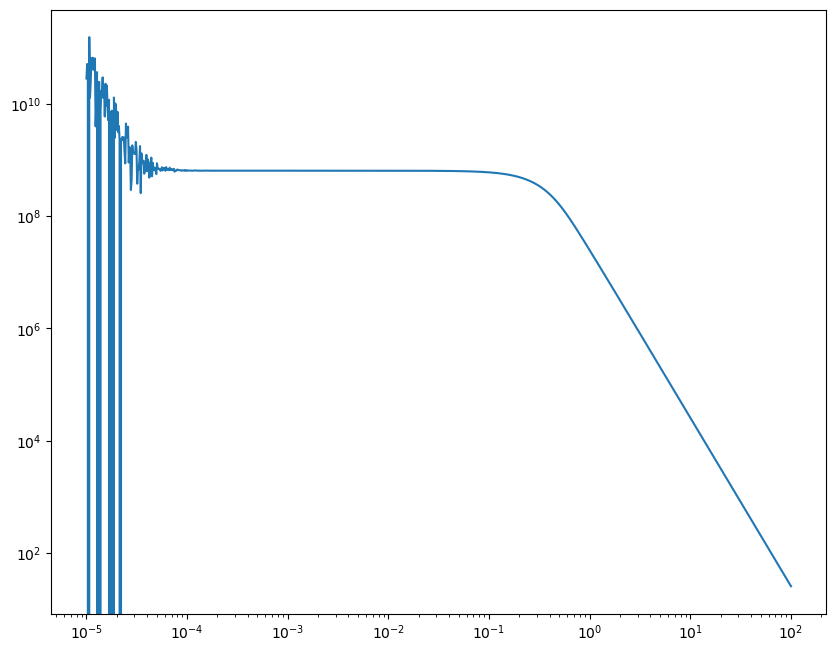

In [39]:
Y = np.logspace(-5, 2, 1000)
ν = ν_T_ai(Y, i, a, all_species)
plt.loglog(Y, ν)

In [40]:
ν_T_ai(Y[ν < 0][0], i, a, all_species)

<Quantity -3.66288921e+10 1 / s>

In [41]:
ν_T_ai(0.1, i, a, all_species)

<Quantity 6.01347211e+08 1 / s>

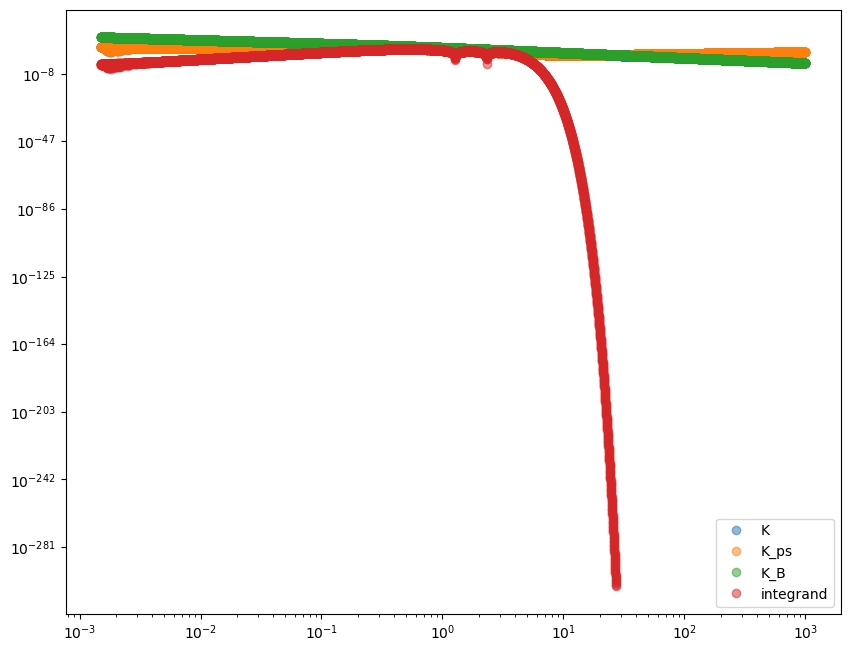

In [46]:
from plasmapy.formulary.neoclassical import K, _integrand

x = np.logspace(np.log10(0.0015), 3, 10000)
kout = K(x, 1, a, all_species, fs)
kpout = K_ps_ai(x, 1, a, all_species, fs)
kbout = K_B_ai(x, 1, a, all_species, fs)
integrand = _integrand(x, 0, 0, 1, a, all_species, fs) 
plt.loglog(x, kout, "o", label="K", alpha=0.5)
plt.loglog(x, kpout, "o", label="K_ps", alpha=0.5)
plt.loglog(x, kbout, "o", label="K_B", alpha=0.5)
plt.legend()

But this seems to average out in the end:

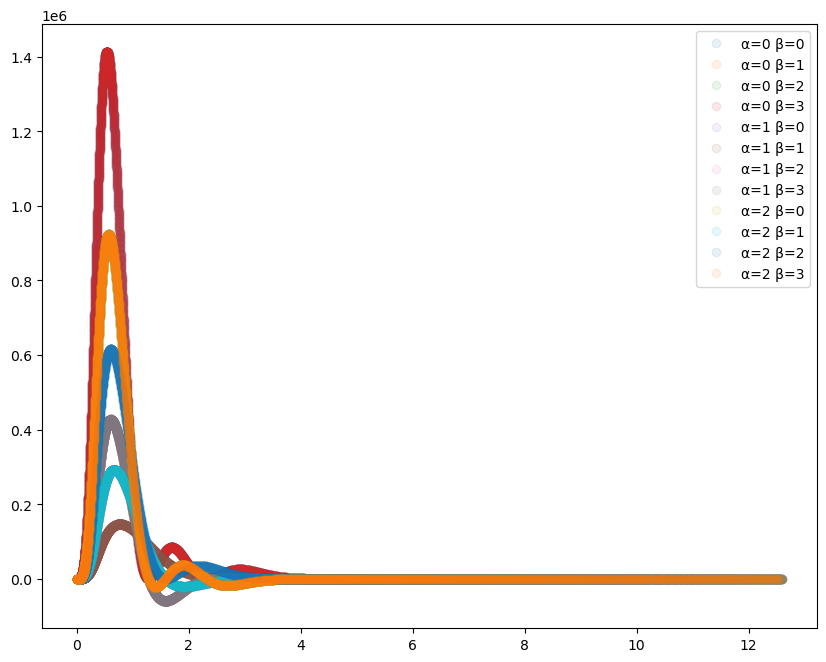

In [53]:
x = np.logspace(np.log10(0.0015), 1.1, 10000)
for α in range(3):
    for β in range(4):
        integrand = _integrand(x, α, β, 1, a, all_species, fs) 
        plt.plot(x, integrand, "o", label=f"{α=} {β=}", alpha=0.1)
plt.legend(loc='best')

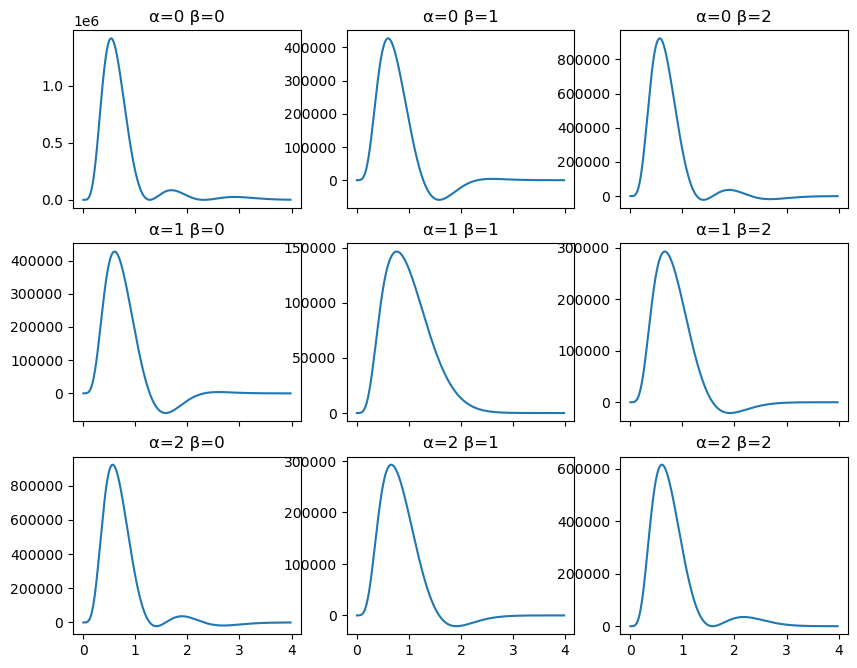

In [65]:
x = np.logspace(np.log10(0.0005), 0.6, 10000)
fig, axes = plt.subplots(3, 3, sharex=True)
for α in range(3):
    for β in range(3):
        integrand = _integrand(x, α, β, 1, a, all_species, fs) 
        axes[α, β].plot(x, integrand)
        axes[α, β].set_title(f"{α=} {β=}")
# plt.legend(loc='best')